In [1]:
import numpy as np
import pyart
import matplotlib.pyplot as plt
import os
#import seaborn as sns; sns.set()

import pickle

import math

import glob
import pandas as pd

from PIL import Image
from string import ascii_lowercase as alphabet


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [71]:
fls = glob.glob('./datasets/TimelapseDay1/*')
fls.sort()

In [8]:
Image.open(fls[-1])._getexif()[36867]

'2016:12:05 07:41:54'

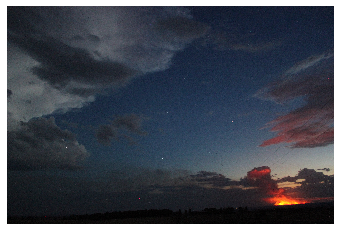

In [10]:
image = plt.imread(fls[-1])
plt.axis('off')
plt.imshow(image)

In [11]:
Image.open(path)._getexif()[36867]

NameError: name 'path' is not defined

In [133]:
def get_date_taken_EXIF(path):
    return pd.to_datetime(Image.open(path)._getexif()[36867], format='%Y:%m:%d %H:%M:%S',utc=True)

def apply_time_correction(df,correct_photo_time,calibration_photo):
    matched_photo_row = df[df.paths.str.contains(calibration_photo)]
    matched_photo_row = df[df.paths.str.contains(calibration_photo)]
    timedelta = matched_photo_row['datetime'] - pd.to_datetime(correct_photo_time,format='%Y-%m-%d %H:%M:%S',utc=True)#.dt.tz_localize('utc')
    print(pd.to_datetime(correct_photo_time,format='%Y-%m-%d %H:%M:%S',utc=True).tz_convert(target_tz))
    df['timedelta'] = timedelta.iloc[0]
    print('offset of {} applied.'.format(timedelta.iloc[0]))
    df['datetime'] = df['datetime'] - df['timedelta']
    df.drop(columns=['timedelta'],inplace=True)
    start_time = df.datetime.min()
    end_time = df.datetime.max()
    print('Data collection start: {}'.format(start_time.tz_convert(target_tz)))
    print('Data collection end: {}'.format(end_time.tz_convert(target_tz)))
    print('Data collection duration: {}'.format(end_time-start_time))
    return df

def load_photo_df(fls):
    photos_df = pd.DataFrame({'paths':fls})
    photos_df['datetime'] = photos_df['paths'].apply(get_date_taken_EXIF)
    return photos_df

#photos_df = photos_df.set_index(['datetime'])
#photos_df = photos_df.loc[~photos_df.index.duplicated(keep='first')]

In [126]:

target_tz = 'Australia/Brisbane'
photos_df = load_photo_df(fls)

In [148]:
correct_photo_time = '2016-12-05 08:43'
calibration_photo = 'IMG_3568.JPG'
photos_df = apply_time_correction(photos_df,correct_photo_time,calibration_photo)

2016-12-05 18:43:00+10:00
offset of 0 days 00:00:00 applied.
Data collection start: 2016-12-05 14:46:12+10:00
Data collection end: 2016-12-05 19:31:21+10:00
Data collection duration: 0 days 04:45:09


In [149]:
photos_df = photos_df.set_index(['datetime'])
photos_df = photos_df.loc[~photos_df.index.duplicated(keep='first')]

In [110]:
def get_nearest_from_ts_index(df,plot_set_timestamps):
    target_idx = []
    for ts in plot_set_timestamps:
        target_idx.append(df.index.get_loc(ts, method='nearest'))
    return df.iloc[target_idx]

In [136]:
plot_set_timestamps_15M = pickle.load( open( "./datasets/plot_set_timestamps_15M.pickle", "rb" ) )

In [150]:
photo_df_15M = get_nearest_from_ts_index(photos_df.sort_index(),plot_set_timestamps_15M)

In [151]:
photo_df_15M

,paths
datetime,
2016-12-05 05:46:01+00:00,./datasets/TimelapseDay1/IMG_1031.JPG
2016-12-05 06:01:01+00:00,./datasets/TimelapseDay1/IMG_1257.JPG
2016-12-05 06:16:01+00:00,./datasets/TimelapseDay1/IMG_1483.JPG
2016-12-05 06:31:02+00:00,./datasets/TimelapseDay1/IMG_1709.JPG
2016-12-05 06:46:02+00:00,./datasets/TimelapseDay1/IMG_1917.JPG
2016-12-05 07:00:59+00:00,./datasets/TimelapseDay1/IMG_2143.JPG
2016-12-05 07:16:00+00:00,./datasets/TimelapseDay1/IMG_2369.JPG
2016-12-05 07:31:00+00:00,./datasets/TimelapseDay1/IMG_2595.JPG
2016-12-05 07:46:00+00:00,./datasets/TimelapseDay1/IMG_2821.JPG


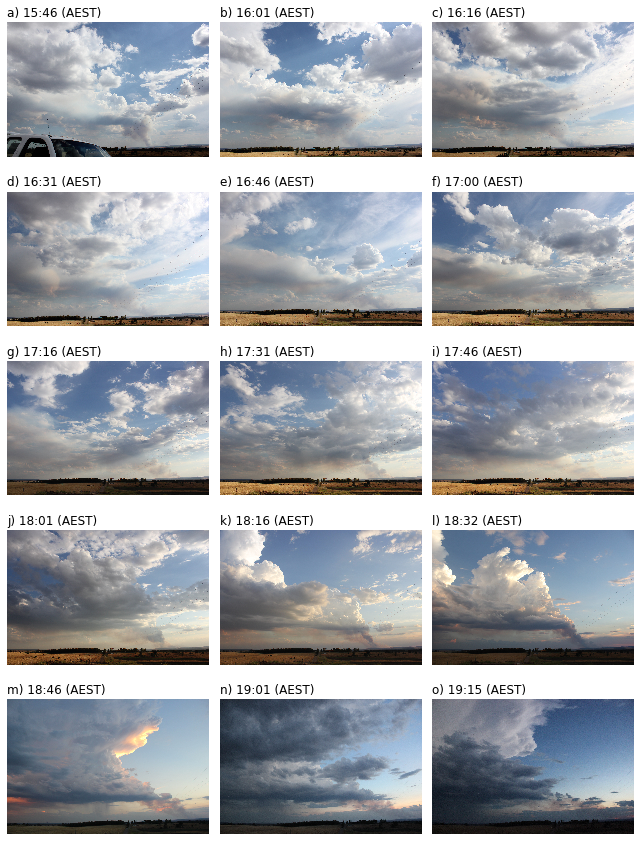

In [161]:
save = True
nrow = 5; ncol = 3;
assert nrow*ncol == len(photo_df_15M)
target_tz = 'Australia/Brisbane'
target_tz_name = 'AEST'
time_str_format = '%H:%M'
time_str_format_map = '%d/%m/%Y %H:%M'
save_str = './timelapse_15M.png'

fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(9,12),sharex=True)

for i, ax in enumerate(axs.reshape(-1)):
    image = plt.imread(photo_df_15M.paths.iloc[i])
    ax.axis('off')
    ax.imshow(image, interpolation='none')
    ds_string = '{} ({})'.format(photo_df_15M.index[i].tz_convert(target_tz).strftime(time_str_format),
                                 target_tz_name)
    ax.set_title('{}) {}'.format(alphabet[i],ds_string),loc='left')
    #ax.text(.85,.8,'{}) {}'.format(alphabet[i],ds_string),
        #horizontalalignment='right')


fig.canvas.draw()
plt.tight_layout()

if save:
    plt.savefig(save_str,dpi=300)
plt.show()